In [1]:
	
%load_ext autoreload
%autoreload 2
import numpy  as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from common import viz
from common import hallmark as hm

In [2]:
def getdist(path, dist):
    df = pd.read_csv(path, sep='\t')
    return df[dist].values

pf = hm.ParaFrame('cache/SPO2023/summ2/{NGC}_a{aspin:g}_i{inc:g}_{freq}.tsv')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

freq = ['86.e9', '230.e9', '345.e9']
cols = ['time', 'Mdot', 'Ftot', 'alpha0', 'beta0', 'major_FWHM', 'minor_FWHM', 'PA', 'mavg', 'vavg', 'beta_2_phase', 'tauI', 'tauF'] 


aspin [-0.94 -0.5   0.    0.5   0.94]
freq ['86.e9']
inc [50.]
NGC ['NGC3998' 'NGC4261' 'NGC4594']


In [4]:
def corr_table(df):
    corr = np.empty((len(cols), len(cols)))
    pvalue = np.empty((len(cols), len(cols)))
    relation = np.empty((len(cols), len(cols)))

    for r in cols:
        for c in cols:
            corr_value, p_value = pearsonr(df[r], df[c])
            corr[cols.index(r)][cols.index(c)] = round(corr_value, 4)
            if p_value > 0.05:
                p_value = 1
                relation[cols.index(r)][cols.index(c)] = round(corr_value, 4)
            else:
                relation[cols.index(r)][cols.index(c)] = round(corr_value, 4)
            pvalue[cols.index(r)][cols.index(c)] = round(p_value, 4)

    corr = pd.DataFrame(corr, columns=cols, index=cols)
    pvalue = pd.DataFrame(pvalue, columns=cols, index=cols)
    relation = pd.DataFrame(relation, columns=cols, index=cols)
    return corr, pvalue, relation

In [26]:
def plot(ax, pf):
    df = pd.read_csv(pf.path.iloc[0], sep='\t')

    df = np.log(df)
    corr = df[cols].corr()

    # Filter the corr to find pattern more easily
    #for col in corr.columns:
    #    corr[col] = np.where(abs(corr[col])<0.5, 0, corr[col]) 

    # Plot graph
    ax.imshow(corr, vmin=-1, vmax=1, cmap='bwr')

    # Formatting
    ax.set_yticks(range(len(cols)), cols)
    ax.set_xticks(range(len(cols)), cols, rotation='vertical')


if False:
    for obj in NGC:
        for i in inc:
            viz.grid(pf(NGC=obj)(inc=i), plot, aspin=aspin, freq=freq,
                    title=f'Correlation table of {obj} $i$={i}', figsize=(12,12),
                    xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                    #fout=f'output/plot/dist/{obj}_{i}'
                    )

In [26]:
aspin[:3]

array([-0.94, -0.5 ,  0.  ])

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

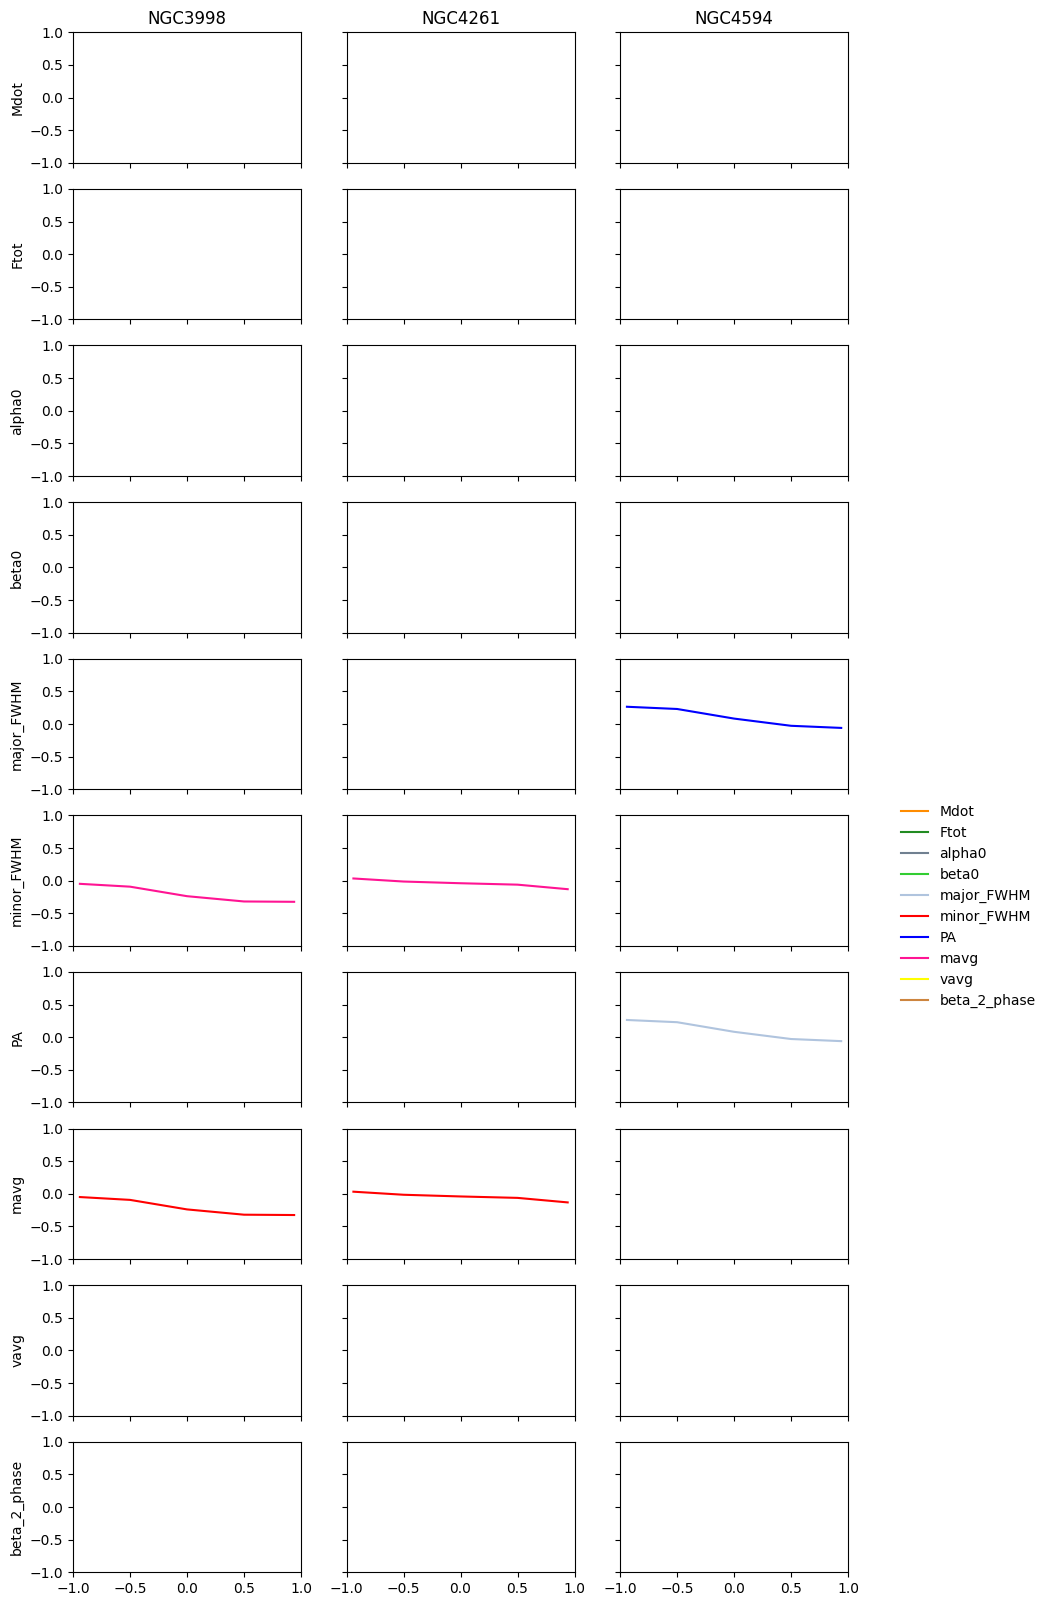

In [11]:
settings = {
    'Mdot': 'darkorange',
    'Ftot': 'forestgreen',
    'alpha0': 'slategray', 
    'beta0': 'limegreen', 
    'major_FWHM': 'lightsteelblue', 
    'minor_FWHM': 'red', 
    'PA': 'blue',
    'mavg': 'deeppink', 
    'vavg': 'yellow', 
    'beta_2_phase': 'peru', 
}

from matplotlib import lines as mlines
new_cols = list(settings.keys())
def trend(pf):
    x = [0, 0.5, 0.94]
    #x = aspin
    fig, axes = plt.subplots(len(new_cols), len(NGC), figsize=(10, 20))
    for i, obj in enumerate(NGC): #column
        for j, var in enumerate(new_cols): #row
            ax = axes[j][i]
            for item in new_cols:
                lst = []
                for a in aspin:
                    df = pd.read_csv(pf(NGC=obj)(aspin=a).path.iloc[0], sep='\t')
                    #df = df.tail(1000)
                    # change absolute alpha0 and beta0 to relative
                    df['alpha0'] = df['alpha0'] - df['alpha0'].iloc[0]
                    df['beta0'] = df['beta0'] - df['beta0'].iloc[0]

                    # sine the beta_2_phase for correlation
                    #df['beta_2_phase'] = np.sin(df['beta_2_phase']*np.pi/180)
                    #print(df)
                    corr = df[new_cols].corr()
                    lst.append(corr.at[var, item])

                # Plot graph if there is a increase/decreasing trend
                if all(j < k for j, k in zip(lst, lst[1:])) or all(j > k for j, k in zip(lst, lst[1:])):
                    ax.plot(aspin, lst, color=settings[item], label=item)
                if all(j > 0 for j in lst[3:]) and all(k < 0 for k in lst[:3]):
                    ax.plot(aspin, lst, color=settings[item], label=item)

            # Formatting
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
            if i == 0: 
                ax.set_ylabel(var)
            else: ax.set_yticklabels([])

            if j == 0: ax.set_title(obj)
            if j != len(new_cols) - 1: ax.set_xticklabels([])

    legend_lst = []
    for var in new_cols:
        legend_lst.append(mlines.Line2D([], [], color=settings[var], label=var))
    fig.legend(handles=legend_lst, frameon=False, bbox_to_anchor=(1.1, 0.5))
    plt.setp(axes, xlim=(-1, 1), ylim=(-1, 1))


i = 50
for f in ['86.e9']:
    trend(pf(freq=f)(inc=i))
    plt.show()

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

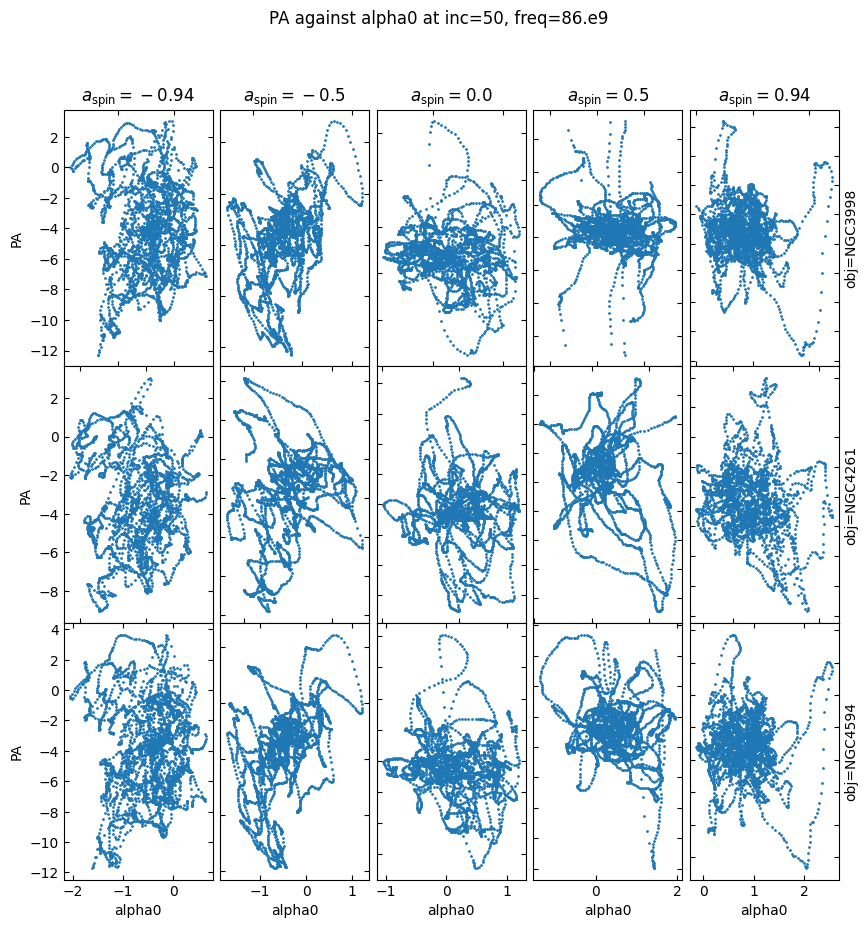

In [4]:
x = 'alpha0'
y = 'PA'

def check_rel(ax, pf):
    df = pd.read_csv(pf.path.iloc[0], sep='\t')
    df['alpha0'] = df['alpha0'] - df['alpha0'].iloc[0]
    ax.scatter(df[x], df[y], s=1)

    #ax.set_yscale('log')

for f in ['86.e9']:
    for i in [50]:
        fig = viz.grid(pf(freq=f)(inc=i), check_rel, aspin=aspin, NGC=NGC, figsize=(10, 10),
                    title=f'{y} against {x} at inc={i}, freq={f}',
                    xlabel=x, ylabel=y,
                    xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'obj={}',)

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

Text(0, 0.5, 'PA [deg]')

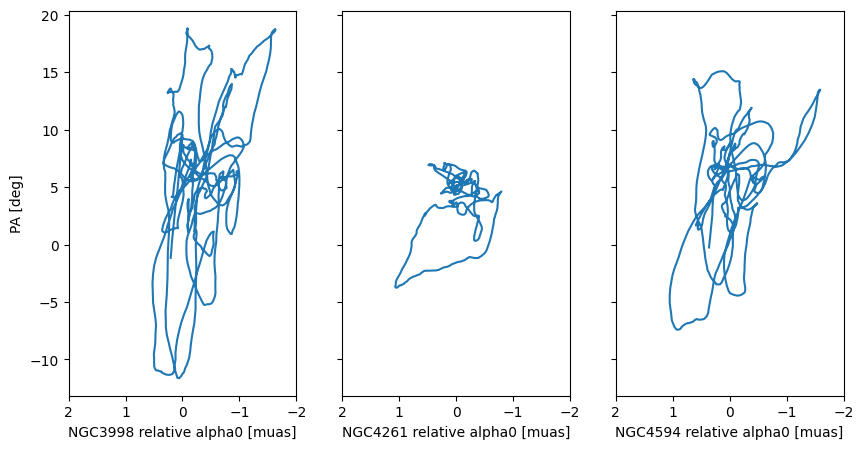

In [150]:
temp = pf(aspin=0.5)(freq='86.e9')(NGC='NGC4261')(inc=50)
temp_df = pd.read_csv(temp.path.iloc[0], sep='\t')
temp_df['alpha0'] = temp_df['alpha0'] - temp_df['alpha0'].iloc[0]

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(10, 5))
for i in range(3):
    temp = pf(aspin=0.5)(freq='86.e9')(NGC=NGC[i])(inc=50)
    temp_df = pd.read_csv(temp.path.iloc[0], sep='\t')
    temp_df['alpha0'] = temp_df['alpha0'] - temp_df['alpha0'].iloc[0]
    ax[i].plot(temp_df[x], temp_df[y])
    ax[i].set_xlabel(f'{NGC[i]} relative {x} [muas]')
    ax[i].set_xlim(2, -2)
ax[0].set_ylabel(f'{y} [deg]')


In [147]:
temp_df = pd.DataFrame()
temp_df = pd.concat([temp_df, pd.DataFrame({'alpha0': df['alpha0'], 'PA':df['PA']})])
temp_df

,alpha0,PA
0,0.000000,79.436246
1,-0.024826,77.781696
2,-0.026240,77.022824
3,-0.022814,75.898149
4,-0.026070,74.360035
...,...,...
995,0.108576,53.245746
996,0.079678,49.787620
997,0.050189,46.296330
998,0.024870,42.962978
